# YOLOv8 with SAM

## Import Packages

In [1]:
import ultralytics
from IPython.display import display, Image
from roboflow import Roboflow
import cv2
import sys
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
device = "cuda"
ultralytics.checks()

Ultralytics YOLOv8.0.110 ðŸš€ Python-3.11.3 torch-2.0.1 CUDA:0 (Tesla V100-SXM2-16GB, 16160MiB)
Setup complete âœ… (8 CPUs, 29.4 GB RAM, 333.1/344.3 GB disk)


In [2]:
first_run = False
if first_run:
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

## Load Dataset

In [3]:
rf = Roboflow(api_key="API_KEY")
project = rf.workspace("vkr-v2").project("vkrrr")
dataset = project.version(5).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics<=8.0.20 is required but found version=8.0.110, to fix: `pip install ultralytics<=8.0.20`


Extracting Dataset Version Zip to VKRRR-5 in yolov8:: 100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 6844/6844 [00:02<00:00, 2493.51it/s]


## Set YOLOv8

In [4]:
!yolo predict model=yolov8n.pt source='./VKRRR-5/train/images/Screenshot_34_jpg.rf.405da21fe26c446900db67a5e8eaadf3.jpg'

Ultralytics YOLOv8.0.110 ðŸš€ Python-3.11.3 torch-2.0.1 CUDA:0 (Tesla V100-SXM2-16GB, 16160MiB)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients

image 1/1 /home/arty/SAM/VKRRR-5/train/images/Screenshot_34_jpg.rf.405da21fe26c446900db67a5e8eaadf3.jpg: 320x640 1 person, 1 train, 56.4ms
Speed: 12.5ms preprocess, 56.4ms inference, 37.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict12


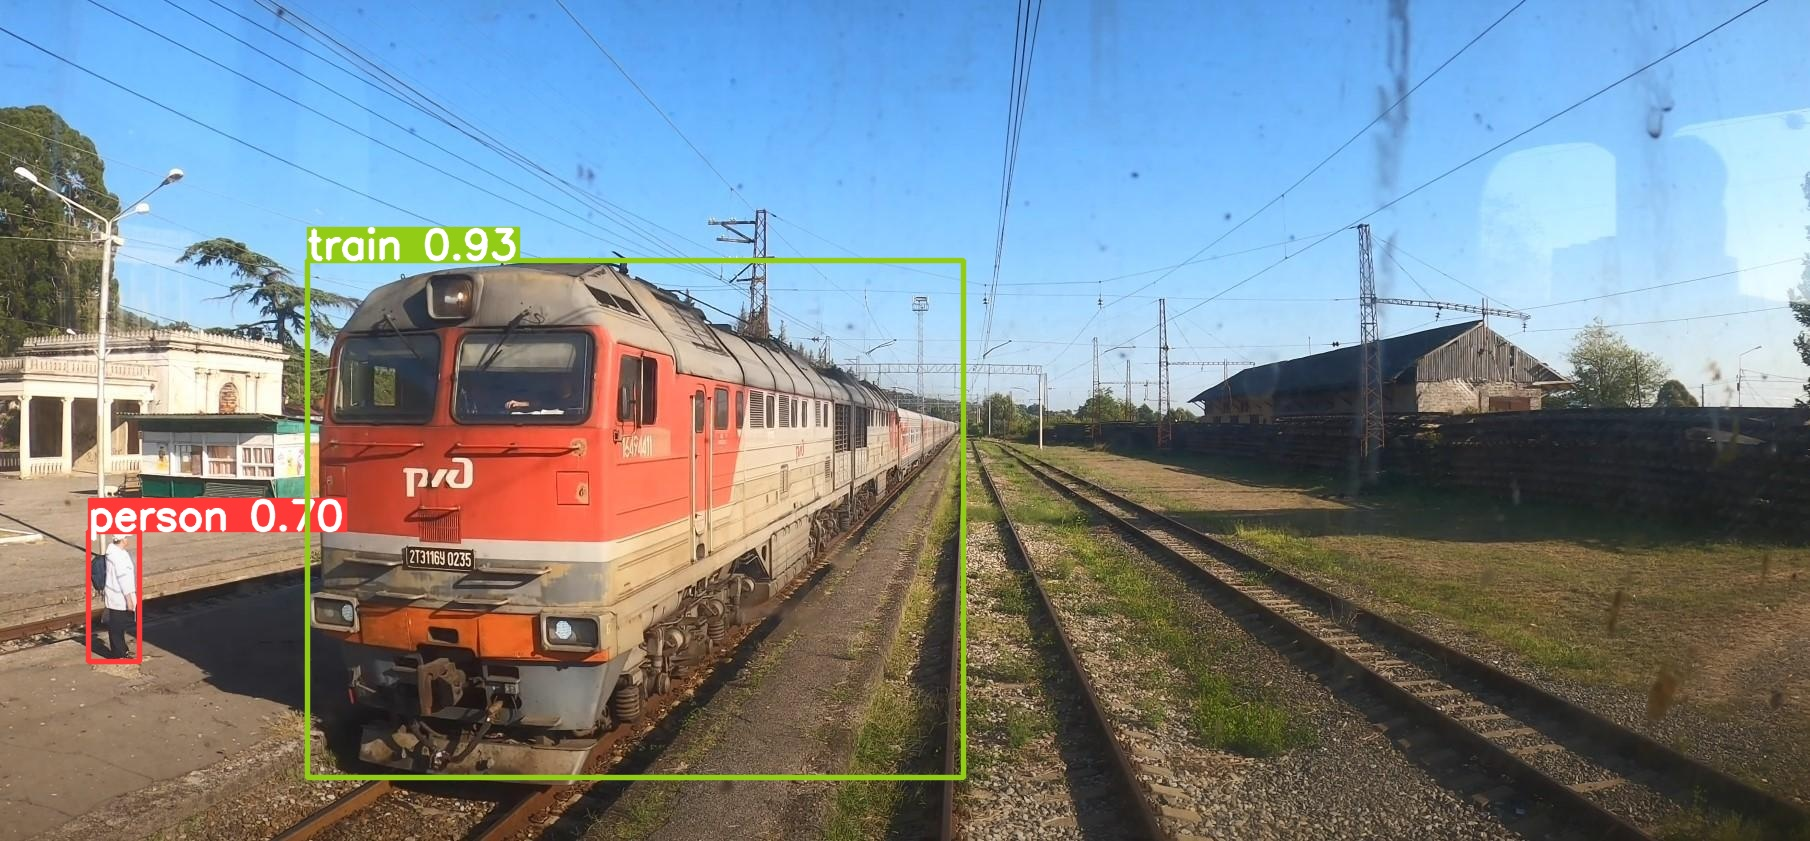

In [5]:
Image(filename='runs/detect/predict7/Screenshot_34_jpg.rf.405da21fe26c446900db67a5e8eaadf3.jpg', height=600)

In [6]:
from ultralytics import YOLO
model = YOLO('yolov8n.pt')
results = model.predict(source='./VKRRR-5/train/images/Screenshot_34_jpg.rf.405da21fe26c446900db67a5e8eaadf3.jpg', conf=0.25)


image 1/1 /home/arty/SAM/VKRRR-5/train/images/Screenshot_34_jpg.rf.405da21fe26c446900db67a5e8eaadf3.jpg: 320x640 1 person, 1 train, 56.3ms
Speed: 5.3ms preprocess, 56.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


In [7]:
results

[ultralytics.yolo.engine.results.Results object with attributes:
 
 boxes: ultralytics.yolo.engine.results.Boxes object
 keypoints: None
 keys: ['boxes']
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair',

## Extract Bounding Box

In [8]:
for result in results:
    boxes = result.boxes  # Boxes object for bbox outputs

bbox=boxes.xyxy.tolist()[0]

In [9]:
bbox

[307.5843200683594, 260.9956970214844, 963.8399658203125, 777.3654174804688]

In [10]:
image = cv2.cvtColor(cv2.imread('./VKRRR-5/train/images/Screenshot_34_jpg.rf.405da21fe26c446900db67a5e8eaadf3.jpg'), cv2.COLOR_BGR2RGB)

In [11]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)
predictor.set_image(image)

In [12]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [13]:
input_box = np.array(bbox)

## Convert Bounding Box to Segmentation Mask

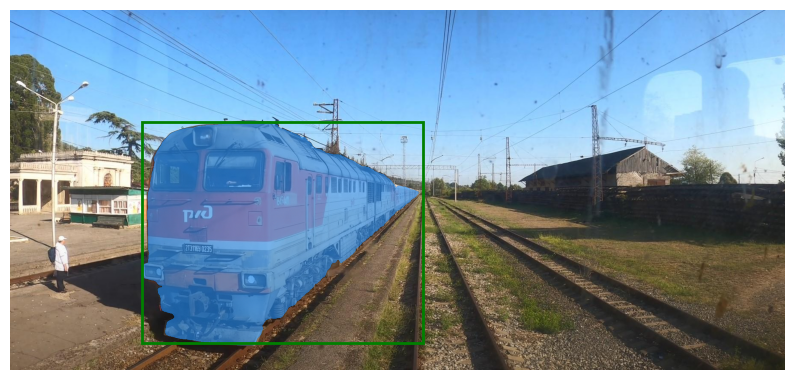

In [14]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

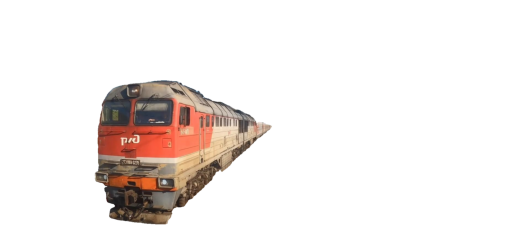

In [15]:
segmentation_mask = masks[0]

binary_mask = np.where(segmentation_mask > 0.5, 1, 0)
white_background = np.ones_like(image) * 255
new_image = white_background * (1 - binary_mask[..., np.newaxis]) + image * binary_mask[..., np.newaxis]
plt.imshow(new_image.astype(np.uint8))
plt.axis('off')
plt.show()
